# %%[markdown]

 Author: Nelson Liu

 Email: [nliu@uncharted.software](mailto:nliu@uncharted.software)

# %%[markdown]

 # Monthly Demo (2024-08)

 1. 6-month evaluation, scenario 2
 2. 12-month evaluation, scenario 1
 3. 12-month evaluation, scenario 2

In [ ]:
# %%

import os
import json
import mira.metamodel
import numpy
import sympy
import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import pytest
import torch
import copy

import pyciemss
from pyciemss.integration_utils.intervention_builder import (
    combine_static_parameter_interventions,
    param_value_objective,
    start_time_objective,
    start_time_param_value_objective,
    intervention_func_combinator,
)
from pyciemss.ouu.qoi import obs_max_qoi


import mira
from mira.sources import biomodels
from mira.modeling.viz import GraphicalModel
from mira.modeling.amr.petrinet import template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
# from mira.metamodel import *
# from mira.modeling import Model

from mira.modeling.amr.ops import *
from mira.metamodel.io import expression_to_mathml


os.environ["MIRA_REST_URL"] = "http://34.230.33.149:8771/api"

In [ ]:
# %%

# Helper functions

# Generate Sympy equations from a template model
def generate_odesys(model, latex: bool = False, latex_align: bool = False) -> list:

    odeterms = {var: 0 for var in model.get_concepts_name_map().keys()}

    for t in model.templates:
        if hasattr(t, "subject"):
            var = t.subject.name
            odeterms[var] -= t.rate_law.args[0]
        
        if hasattr(t, "outcome"):
            var = t.outcome.name
            odeterms[var] += t.rate_law.args[0]

    # Time
    symb = lambda x: sympy.Symbol(x)
    try:
        time = model.time.name
    except:
        time = "t"
    finally:
        t = symb(time)

    # Construct Sympy equations
    odesys = [
        sympy.Eq(sympy.diff(sympy.Function(var)(t), t), terms) 
        if latex == False
        else sympy.latex(sympy.Eq(sympy.diff(sympy.Function(var)(t), t), terms))
        for var, terms in odeterms.items()
    ]
    
    if (latex == True) & (latex_align == True):
        odesys = "\\begin{align*} \n    " + " \\\\ \n    ".join([eq.replace(" = ", " &= ") for eq in odesys]) + "\n\\end{align*}"
        # odesys = "\\begin{align*}     " + " \\\\    ".join([eq.replace(" = ", " &= ") for eq in odesys]) + "\\end{align*}"

    return odesys

# Generate summary table of a template model
def generate_summary_table(model) -> pandas.DataFrame:

    data = {"name": [t.name for t in model.templates]}
    for k in ("subject", "outcome", "controller"):
        data[k] = [getattr(t, k).name if hasattr(t, k) else None for t in model.templates]

    data["controllers"] = [[c.name for c in getattr(t, k)] if hasattr(t, "controllers") else None for t in model.templates]
    data["controller(s)"] = [i if j == None else j for i, j in zip(data["controller"], data["controllers"])]
    __ = data.pop("controller")
    __ = data.pop("controllers")

    data["rate_law"] = [t.rate_law for t in model.templates]
    data["interactor_rate_law"] = [t.get_interactor_rate_law() for t in model.templates]

    df = pandas.DataFrame(data)

    return df

# Generate initial condition and parameter tables
def generate_init_param_tables(model) -> tuple[pandas.DataFrame, pandas.DataFrame]:

    data = {}
    data["name"] = [name for name, __ in model.initials.items()]
    data["expression"] = [init.expression for __, init in model.initials.items()]
    df_initials = pandas.DataFrame(data)

    data = {}
    data["name"] = [name for name, __ in model.parameters.items()]
    data["value"] = [param.value for __, param in model.parameters.items()]
    df_params = pandas.DataFrame(data)

    return (df_initials, df_params)

# Plot pyciemss.simulate results
def plot_simulate_results(results: dict) -> None:

    colors = mpl.colormaps["tab10"](range(10))
    df = results["data"].groupby(["timepoint_id"]).mean()

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))

    i = 0
    names = []
    for c in results["data"].columns:
        if c.split("_")[-1] == "state":
            for n in range(num_samples):
                df = results["data"][results["data"]["sample_id"] == n]
                __ = ax.plot(df["timepoint_unknown"], df[c], label = c, alpha = 0.5, color = colors[i, :])
            
            names.append(c)
            i += 1

    __ = ax.legend(handles = [mpl.lines.Line2D([0], [0], alpha = 0.5, color = colors[j, :], label = names[j]) for j in range(i)])

    return None

# Workaround for adding missing names/display_names in AMR
def add_missing_parameter_names(amr: dict) -> dict:

    for param in amr["semantics"]["ode"]["parameters"]:
        if "name" not in param.keys():
            param["name"] = param["id"]

    return amr

# Workaround for adding distributions to parameters
def add_missing_distributions(amr: dict) -> dict:

    for param in amr["semantics"]["ode"]["parameters"]:
        if ("value" in param.keys()):

            d = param["value"] * 0.01
            if numpy.abs(param["value"]) == 0.0:
                d = 0.01
                min = param["value"]
                max = param["value"] + d
            else:
                min = param["value"] - d
                max = param["value"] + d
            

            param["distribution"] = {
                "type": "StandardUniform1",
                "parameters": {
                    "minimum": min,
                    "maximum": max
                }
            }

    return amr

# %%[markdown]

 ## Problem 1

 6-month evaluation, scenario 2

 1. Start with published SIDARTHE model
 2. Unit Test 1: Configure it as per the paper, run the model, and compare the results
 3. Unit Test 2: Configure with interventions, run the model, and compare the results with Fig. 2B of the paper.
 4. Create SIDARTHE-V model by editing the SIDARTHE model
 5. Find optimal policy (at timepoint 30 days) for SIDARTHE-V to keep R0 < 1.0

In [ ]:
# %%

# Load the SIDARTHE model from the BioModels DB
# (Need to apply `simplify_rate_laws`)

model_sidarthe = biomodels.get_template_model("BIOMD0000000955")
model_sidarthe = mira.metamodel.ops.simplify_rate_laws(model_sidarthe)
model_sidarthe.eliminate_unused_parameters()

# workaround
amr = add_missing_distributions(add_missing_parameter_names(template_model_to_petrinet_json(model_sidarthe)))
model_sidarthe = template_model_from_amr_json(amr)

In [ ]:
# %%

# Save as AMR
with open("./data/monthly_demo_202408/model_sidarthe.json", "w") as f:
    j = template_model_to_petrinet_json(model_sidarthe)
    json.dump(j, f, indent = 4)

In [ ]:
# %%

# Add an observable `TotalInfected` =  I + D + A + R + T
model_sidarthe.observables["TotalInfected"] = mira.metamodel.template_model.Observable(
    name = "TotalInfected", 
    expression = sympy.Symbol("Infected") + sympy.Symbol("Diagnosed") + sympy.Symbol("Ailing") + sympy.Symbol("Recognized") + sympy.Symbol("Threatened")
)

In [ ]:
# %%

# Add an observable `R0`
# 
# r1 = epsilon + eta + lambda
# r2 = eta + rho
# r3 = theta + mu + kappa
# r4 = nu + xi
# r5 = sigma + tau
# 
# R0 = alpha / r1
# + (beta * epsilon) / (r1 * r2) 
# + (gamma * zeta) / (r1 * r3) 
# + (delta * eta * epsilon) / (r1 * r2 * r4) 
# + (delta * zeta * theta) / (r1 * r3 * r4)

model_sidarthe.observables["R0"] = mira.metamodel.template_model.Observable(
    name = "R0", 
    expression = sympy.Symbol("alpha") / (sympy.Symbol("epsilon") + sympy.Symbol("eta") + sympy.Symbol("lambda"))
        + (sympy.Symbol("beta") * sympy.Symbol("epsilon")) / ((sympy.Symbol("epsilon") + sympy.Symbol("eta") + sympy.Symbol("lambda")) * (sympy.Symbol("eta") + sympy.Symbol("rho"))) 
        + (sympy.Symbol("gamma") * sympy.Symbol("zeta")) / ((sympy.Symbol("epsilon") + sympy.Symbol("eta") + sympy.Symbol("lambda")) * (sympy.Symbol("theta") + sympy.Symbol("mu") + sympy.Symbol("kappa"))) 
        + (sympy.Symbol("delta") * sympy.Symbol("eta") * sympy.Symbol("epsilon")) / ((sympy.Symbol("epsilon") + sympy.Symbol("eta") + sympy.Symbol("lambda")) * (sympy.Symbol("eta") + sympy.Symbol("rho")) * (sympy.Symbol("nu") + sympy.Symbol("xi"))) 
        + (sympy.Symbol("delta") * sympy.Symbol("zeta") * sympy.Symbol("theta")) / ((sympy.Symbol("epsilon") + sympy.Symbol("eta") + sympy.Symbol("lambda")) * (sympy.Symbol("theta") + sympy.Symbol("mu") + sympy.Symbol("kappa")) * (sympy.Symbol("nu") + sympy.Symbol("xi")))
)

# Rename the model
model_sidarthe.annotations.name = "SIDARTHE model with observables"

In [ ]:
# %%

# Save as AMR
with open("./data/monthly_demo_202408/model_sidarthe_with_observable.json", "w") as f:
    j = template_model_to_petrinet_json(model_sidarthe)
    json.dump(j, f, indent = 4)

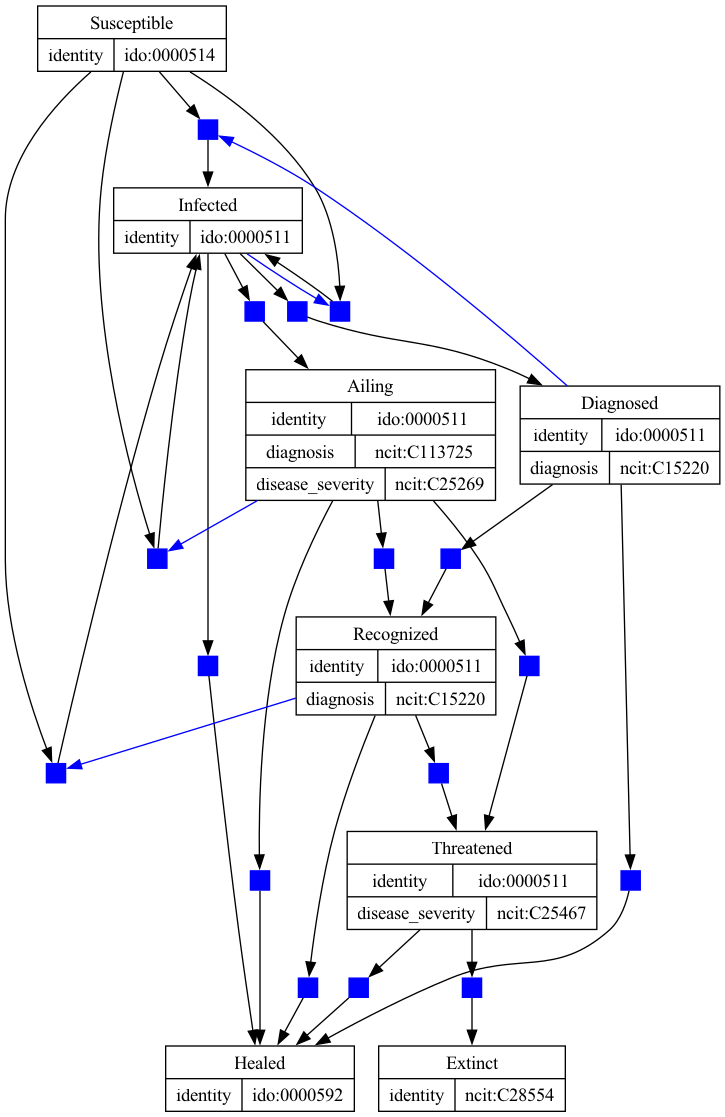

In [ ]:
# %%

GraphicalModel.for_jupyter(model_sidarthe)

In [ ]:
# %%

__ = [print(eq) for eq in generate_odesys(model_sidarthe)]

Eq(Derivative(Susceptible(t), t), -Ailing*Susceptible*gamma - Diagnosed*Susceptible*beta - Infected*Susceptible*alpha - Recognized*Susceptible*delta)
Eq(Derivative(Infected(t), t), Ailing*Susceptible*gamma + Diagnosed*Susceptible*beta + Infected*Susceptible*alpha - Infected*epsilon - Infected*lambda - Infected*zeta + Recognized*Susceptible*delta)
Eq(Derivative(Diagnosed(t), t), -Diagnosed*eta - Diagnosed*rho + Infected*epsilon)
Eq(Derivative(Ailing(t), t), -Ailing*kappa - Ailing*mu - Ailing*theta + Infected*zeta)
Eq(Derivative(Recognized(t), t), Ailing*theta + Diagnosed*eta - Recognized*nu - Recognized*xi)
Eq(Derivative(Healed(t), t), Ailing*kappa + Diagnosed*rho + Infected*lambda + Recognized*xi + Threatened*sigma)
Eq(Derivative(Threatened(t), t), Ailing*mu + Recognized*nu - Threatened*sigma - Threatened*tau)
Eq(Derivative(Extinct(t), t), Threatened*tau)


In [ ]:
# %%

generate_summary_table(model_sidarthe)

,name,subject,outcome,controller(s),rate_law,interactor_rate_law
0,t1,Susceptible,Infected,Diagnosed,Diagnosed*Susceptible*beta,Diagnosed*Susceptible
1,t2,Susceptible,Infected,Ailing,Ailing*Susceptible*gamma,Ailing*Susceptible
2,t3,Susceptible,Infected,Recognized,Recognized*Susceptible*delta,Recognized*Susceptible
3,t4,Susceptible,Infected,Infected,Infected*Susceptible*alpha,Infected*Susceptible
4,t5,Infected,Diagnosed,None,Infected*epsilon,Infected
5,t6,Infected,Ailing,None,Infected*zeta,Infected
6,t7,Infected,Healed,None,Infected*lambda,Infected
7,t8,Diagnosed,Recognized,None,Diagnosed*eta,Diagnosed
8,t9,Diagnosed,Healed,None,Diagnosed*rho,Diagnosed
9,t10,Ailing,Recognized,None,Ailing*theta,Ailing


In [ ]:
# %%

df_initials, df_params = generate_init_param_tables(model_sidarthe)
df_initials

,name,expression
0,Susceptible,0.9999963
1,Diagnosed,3.33333333e-7
2,Infected,3.33333333e-6
3,Ailing,1.66666666e-8
4,Recognized,3.33333333e-8
5,Healed,0.0
6,Threatened,0.0
7,Extinct,0.0


In [ ]:
# %%

df_params

,name,value
0,beta,0.011
1,gamma,0.456
2,delta,0.011
3,alpha,0.570
4,epsilon,0.171
5,zeta,0.125
6,lambda,0.034
7,eta,0.125
8,rho,0.034
9,theta,0.371


In [ ]:
# %%

# Check configuration:
# 
# N = 60e6
# I = 200/N
# D = 20/N
# A = 1/N
# T = H = E = 0
# S = 1 - I - D - A - R - T - H - E

assert float(str(model_sidarthe.initials["Infected"].expression.evalf())) == pytest.approx(200 / 60e6)
assert float(str(model_sidarthe.initials["Diagnosed"].expression.evalf())) == pytest.approx(20 / 60e6)
assert float(str(model_sidarthe.initials["Ailing"].expression.evalf())) == pytest.approx(1 / 60e6)
assert float(str(model_sidarthe.initials["Threatened"].expression.evalf())) == pytest.approx(0)
assert float(str(model_sidarthe.initials["Healed"].expression.evalf())) == pytest.approx(0)
assert float(str(model_sidarthe.initials["Extinct"].expression.evalf())) == pytest.approx(0)
assert float(str(model_sidarthe.initials["Susceptible"].expression.evalf())) == pytest.approx(1 - (200 + 20 + 1)/60e6)

assert model_sidarthe.parameters["alpha"].value == pytest.approx(0.570)
assert model_sidarthe.parameters["beta"].value == pytest.approx(0.011)
assert model_sidarthe.parameters["gamma"].value == pytest.approx(0.456)
assert model_sidarthe.parameters["delta"].value == pytest.approx(0.011)
assert model_sidarthe.parameters["epsilon"].value == pytest.approx(0.171)
assert model_sidarthe.parameters["theta"].value == pytest.approx(0.371)
assert model_sidarthe.parameters["zeta"].value == pytest.approx(0.125)
assert model_sidarthe.parameters["eta"].value == pytest.approx(0.125)
assert model_sidarthe.parameters["mu"].value == pytest.approx(0.017)

assert model_sidarthe.parameters["nu"].value == pytest.approx(0.027)
assert model_sidarthe.parameters["tau"].value == pytest.approx(0.01)
assert model_sidarthe.parameters["lambda"].value == pytest.approx(0.034)
assert model_sidarthe.parameters["rho"].value == pytest.approx(0.034)
assert model_sidarthe.parameters["kappa"].value == pytest.approx(0.017)
assert model_sidarthe.parameters["xi"].value == pytest.approx(0.017)
assert model_sidarthe.parameters["sigma"].value == pytest.approx(0.017)

# %%[markdown]

 ### Unit Test 1

`TotalInfected` reaches a max of 60.0% at timepoint 46.0 days


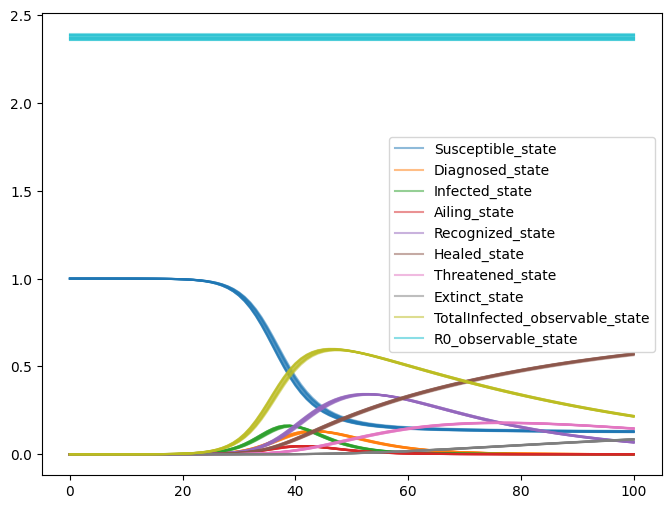

In [ ]:
# %%

# Simulate
start_time = 0.0
end_time = 100.0
logging_step_size = 1.0
num_samples = 10

results = pyciemss.sample(
    add_missing_parameter_names(template_model_to_petrinet_json(model_sidarthe)), 
    end_time, 
    logging_step_size, 
    num_samples, 
    start_time = start_time
)

# Plot results
plot_simulate_results(results)

i = numpy.argmax(results["data"]["TotalInfected_observable_state"])
print(f"`TotalInfected` reaches a max of {results["data"]["TotalInfected_observable_state"].iloc[i] * 100:.1f}% at timepoint {results["data"].iloc[i, :]["timepoint_unknown"]} days")
# `TotalInfected` reaches a max of 59.7% at timepoint 47.0 days

# %%[markdown]

 ### Unit Test 2

In [ ]:
# %%

# Interventions:
# After day 4, α=0.422, β=δ=0.0057 and γ=0.285
# After day 12, we set ε=0.143
# After day 22, α=0.360, β=δ=0.005 and γ=0.200; also, ζ=η=0.034, μ=0.008, ν=0.015, λ=0.08, ρ=κ=ξ=σ=0.017
# After day 28, α=0.210 γ=0.110
# After day 38, ε=0.200, ρ=κ=ξ=0.020, σ=0.010 and ζ=η=0.025

static_parameter_interventions = {
    torch.tensor(4.0): {
        "alpha": torch.tensor(0.422),
        "beta": torch.tensor(0.0057),
        "delta": torch.tensor(0.0057),
        "gamma": torch.tensor(0.285)
    },
    torch.tensor(12.0): {
        "epsilon": torch.tensor(0.143)
    },
    torch.tensor(22.0): {
        "alpha": torch.tensor(0.360),
        "beta": torch.tensor(0.005),
        "delta": torch.tensor(0.005),
        "gamma": torch.tensor(0.200),
        "zeta": torch.tensor(0.034),
        "eta": torch.tensor(0.034),
        "mu": torch.tensor(0.008),
        "nu": torch.tensor(0.015),
        "lambda": torch.tensor(0.08),
        "rho": torch.tensor(0.017),
        "kappa": torch.tensor(0.017),
        "xi": torch.tensor(0.017),
        "sigma": torch.tensor(0.017),
    },
    torch.tensor(28.0): {
        "alpha": torch.tensor(0.210),
        "gamma": torch.tensor(0.110)
    },
    torch.tensor(38.0): {
        "epsilon": torch.tensor(0.200),
        "rho": torch.tensor(0.020),
        "kappa": torch.tensor(0.020),
        "xi": torch.tensor(0.020),
        "sigma": torch.tensor(0.010),
        "zeta": torch.tensor(0.025),
        "eta": torch.tensor(0.025)
    }
}

`TotalInfected` reaches a max of 0.2% at timepoint 50.0 days


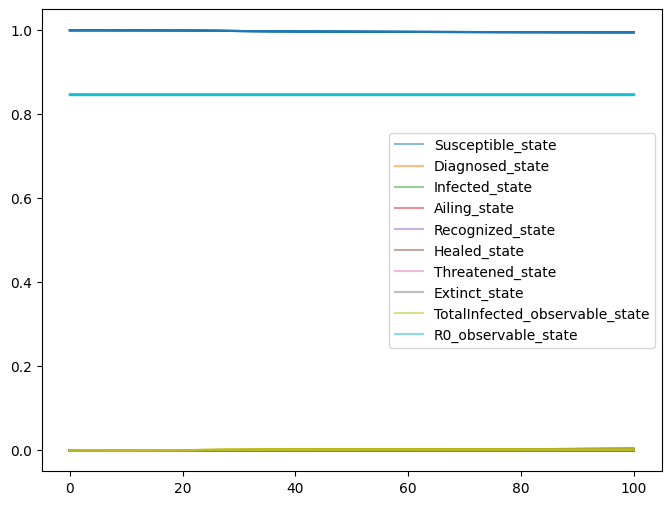

In [ ]:
# %%

# Simulate with interventions
results = pyciemss.sample(
    add_missing_parameter_names(template_model_to_petrinet_json(model_sidarthe)), 
    end_time, 
    logging_step_size, 
    num_samples, 
    start_time = start_time,
    static_parameter_interventions = static_parameter_interventions
)

# Plot results
plot_simulate_results(results)

i = numpy.argmax(results["data"]["TotalInfected_observable_state"])
print(f"`TotalInfected` reaches a max of {results["data"]["TotalInfected_observable_state"].iloc[i] * 100:.1f}% at timepoint {results["data"].iloc[i, :]["timepoint_unknown"]} days")
# `TotalInfected` reaches a max of 0.2% at timepoint 50.0 days

In [ ]:
# %%

# Note:
# Strange that R0 looks constant at its last value (i.e. R0(t = 100) ~ 0.85) for all timepoints
# It should change from 2.38, 1.66, 1.80, 1.60, 0.99, then 0.85

# %%[markdown]

 ### Question 1d

 Assuming all parameters are constant (i.e. no intervention)
 and theta >= 2 * epsilon, find the optimal, minimum value of theta, epsilon
 such that `TotalInfected` < 1/3 of total population

In [ ]:
# %%

# Define optimization problem setup

# Targeted interventions
initial_guess_interventions = [0.171, 2 * 0.171]
bounds_interventions = [[0.0, 2 * 0.0], [0.1711, 2 * 0.1711]]
static_parameter_interventions = param_value_objective(
    param_name = ["epsilon", "theta"],
    param_value = [lambda x: torch.tensor(x), lambda x: torch.tensor(x)],
    start_time = [torch.tensor(1.0), torch.tensor(1.0)],
)

# Success criterion
risk_bound = 1.0 / 3.0
observed_params = ["TotalInfected"]
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: numpy.abs(x)

# Run optimize interface
maxiter = 1
maxfeval = 10
# opt_results = pyciemss.optimize(
#     add_missing_parameter_names(template_model_to_petrinet_json(model_sidarthe)), 
#     end_time,
#     logging_step_size,
#     qoi,
#     risk_bound,
#     static_parameter_interventions,
#     objfun,
#     initial_guess_interventions = initial_guess_interventions,
#     bounds_interventions = bounds_interventions,
#     start_time = start_time,
#     n_samples_ouu = 10,
#     maxiter = maxiter,
#     maxfeval = maxfeval,
#     solver_method = "dopri5",
# )

# print(f'Optimal policy:', opt_results["policy"])
# print(opt_results)

# %%[markdown]

 Note:
 pyciemss.optimize throws error when `observed_params` is an observable (instead of a state variable)

# %%[markdown]

 ### Question 2

 Get SIDARTHE-V model

In [ ]:
# %%

# Add new S -> V template
from mira.examples.concepts import vaccinated
model_sidarthev = model_sidarthe.add_template(
    mira.metamodel.NaturalConversion(
        subject = model_sidarthe.get_concepts_by_name("Susceptible")[0],
        outcome = vaccinated,
        name = "VaccinationProcess"
    )
)

# Add new parameter `phi`
model_sidarthev.add_parameter(
    "phi", "phi", "vaccination rate", 0.01
)

# Specify rate law of the new template using `phi`
model_sidarthev.templates[-1].set_mass_action_rate_law("phi")

# Add a new R -> E template
model_sidarthev = model_sidarthev.add_template(
    mira.metamodel.NaturalConversion(
        subject = model_sidarthev.get_concepts_by_name("Recognized")[0],
        outcome = model_sidarthev.get_concepts_by_name("Extinct")[0],
        name = "RecognizedDeathProcess"
    )
)

# Add new parameter `tau1`
model_sidarthev.add_parameter(
    "tau_1", "tau_1", "recognized death rate", (1.0 / 3.0) * model_sidarthe.parameters["tau"].value
)

# Specify rate law of the new template using `phi`
model_sidarthev.templates[-1].set_mass_action_rate_law("tau_1")

# Rename the `tau` parameter to `tau2`
from mira.modeling.amr.ops import replace_parameter_id
j = template_model_to_petrinet_json(model_sidarthev)
model_sidarthev = template_model_from_amr_json(replace_parameter_id(j, "tau", "tau_2"))

# Rename the model
model_sidarthev.annotations.name = "SIDARTHE-V model"
model_sidarthev.annotations.description = "Edit of the SIDARTHE model from Giodano 2020 to include vaccination."

# Workaround
amr = add_missing_distributions(add_missing_parameter_names(template_model_to_petrinet_json(model_sidarthev)))
model_sidarthev = template_model_from_amr_json(amr)

generate_summary_table(model_sidarthev)

,name,subject,outcome,controller(s),rate_law,interactor_rate_law
0,t1,Susceptible,Infected,Diagnosed,Diagnosed*Susceptible*beta,Diagnosed*Susceptible
1,t2,Susceptible,Infected,Ailing,Ailing*Susceptible*gamma,Ailing*Susceptible
2,t3,Susceptible,Infected,Recognized,Recognized*Susceptible*delta,Recognized*Susceptible
3,t4,Susceptible,Infected,Infected,Infected*Susceptible*alpha,Infected*Susceptible
4,t5,Infected,Diagnosed,None,Infected*epsilon,Infected
5,t6,Infected,Ailing,None,Infected*zeta,Infected
6,t7,Infected,Healed,None,Infected*lambda,Infected
7,t8,Diagnosed,Recognized,None,Diagnosed*eta,Diagnosed
8,t9,Diagnosed,Healed,None,Diagnosed*rho,Diagnosed
9,t10,Ailing,Recognized,None,Ailing*theta,Ailing


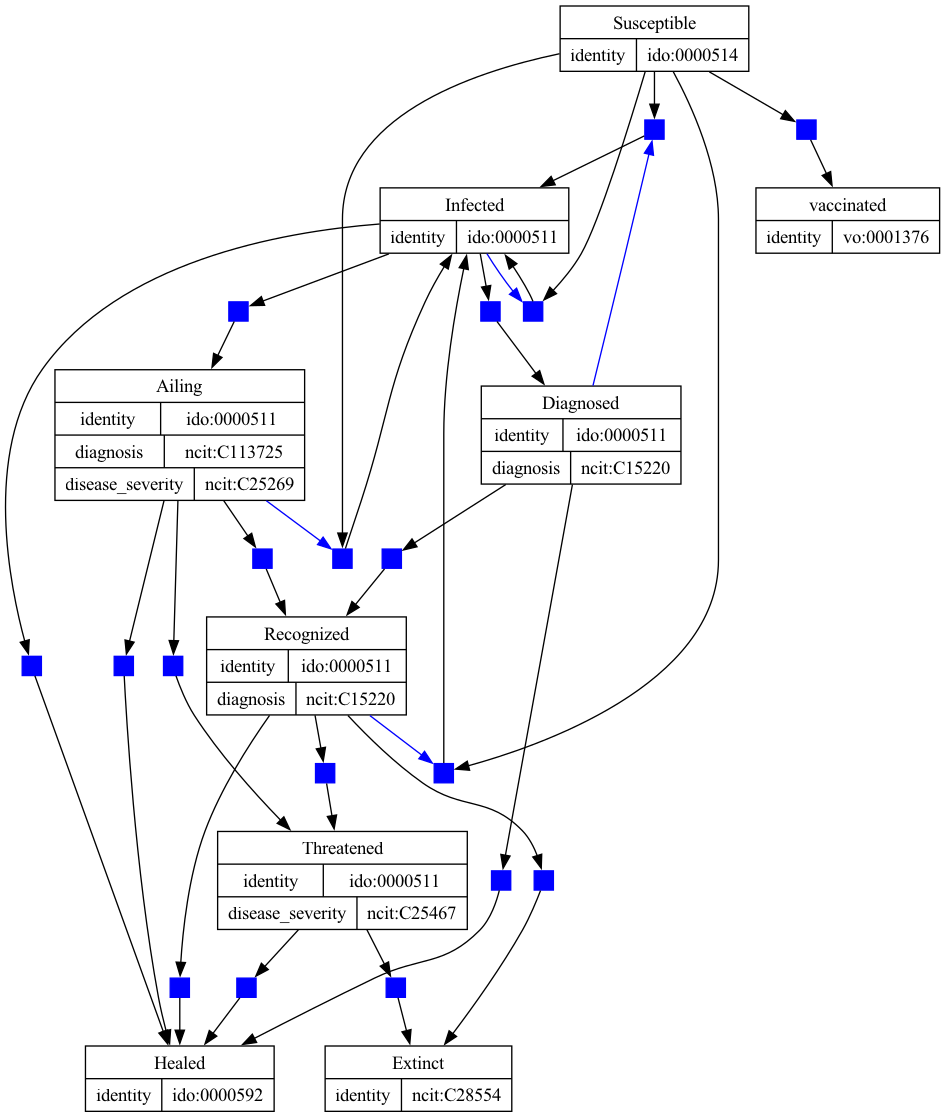

In [ ]:
# %%

GraphicalModel.for_jupyter(model_sidarthev)

In [ ]:
# %%

# Save as AMR
with open("./data/monthly_demo_202408/model_sidarthev.json", "w") as f:
    j = template_model_to_petrinet_json(model_sidarthev)
    json.dump(j, f, indent = 4)

# %%[markdown]

 ### Compare SIDARTHE and SIDARTHE-V

In [ ]:
# %%

from mira.dkg.web_client import is_ontological_child_web
from mira.metamodel import TemplateModelDelta

tmd = TemplateModelDelta(model_sidarthe, model_sidarthev, refinement_function = is_ontological_child_web)

# Show plot...

# %%[markdown]

 ### Question 2bi

 Test all possible static parameter value interventions

# %%[markdown]

 ### Question 2bii

 Use Optimize where R0 is the success criterion target (TBA if an observable can be used this way).

# %%[markdown]

 ## Problem 2

 12-month evaluation, scenario 1

In [ ]:
# %%

# Construct the SEIRHD model by editing the SIDARTHE model?

amr = template_model_to_petrinet_json(model_sidarthe)

# Remove observables
amr = remove_observable(amr, "R0")
amr = remove_observable(amr, "TotalInfected")

# Delete Ailing, Recognized
amr = remove_state(amr, "Ailing")
amr = remove_state(amr, "Recognized")

# Rename the state variables
# Note: need to be able to change the name (not just the ID)
amr = replace_state_id(amr, "Susceptible", "S")
amr = replace_state_id(amr, "Infected", "E")
amr = replace_state_id(amr, "Diagnosed", "I")
amr = replace_state_id(amr, "Healed", "R")
amr = replace_state_id(amr, "Threatened", "H")
amr = replace_state_id(amr, "Extinct", "D")

# Change names
id_name_map = {id: name for id, name in zip(list("SEIRHD"), ["Susceptible", "Exposed", "Infected", "Recovered", "Hospitalized", "Deceased"])}
for i, state in enumerate(amr["model"]["states"]):
    amr["model"]["states"][i]["name"] = id_name_map[state["id"]]

# Remove S -> E controlled by E (template/transition with name "t4")
amr = remove_transition(amr, "t4")

# Remove E -> R (template name "t7")
amr = remove_transition(amr, "t7")

# Add I -> H (rate law = rIH * pIH * I)
from mira.metamodel.io import expression_to_mathml
amr = add_transition(
    amr, 
    new_transition_id = "t17", 
    src_id = "I", 
    tgt_id = "H", 
    rate_law_mathml = expression_to_mathml(sympy.Symbol("rIH") * sympy.Symbol("pIH") * sympy.Symbol("I")),
    params_dict = {
        "rIH": {"value": 1.0},
        "pIH": {"value": 1.0}
    }
)

# Rename parameter from epsilon to rEI
amr = replace_parameter_id(amr, "epsilon", "rEI")

# Replace rate laws to conform to equations
amr = replace_rate_law_sympy(amr, "t1", sympy.Symbol("b") * sympy.Symbol("invN") * sympy.Symbol("I") * sympy.Symbol("S"))
amr = replace_rate_law_sympy(amr, "t9", sympy.Symbol("rIR") * sympy.Symbol("pIR") * sympy.Symbol("I"))
amr = replace_rate_law_sympy(amr, "t15", sympy.Symbol("rHD") * sympy.Symbol("pHD") * sympy.Symbol("H"))
amr = replace_rate_law_sympy(amr, "t16", sympy.Symbol("rHR") * sympy.Symbol("pHR") * sympy.Symbol("H"))

# Convert from AMR JSON back to TemplateModel
tm = template_model_from_amr_json(amr)

# Delete all unused parameters, legacy from SIDARTHE
tm.eliminate_unused_parameters()

# Make sure all used parameters are defined
params = tm.get_all_used_parameters()
tm.update_parameters({p: 1.0 for p in params})

# Make a copy of the final SEIRHD model
model_seirhd = copy.deepcopy(tm)

# Rename the model
model_seirhd.annotations.name = "SEIRHD model"
model_seirhd.annotations.description = "Edit of the SIDARTHE model from Giodano 2020."

# Workaround
amr = add_missing_distributions(add_missing_parameter_names(template_model_to_petrinet_json(model_seirhd)))
model_seirhd = template_model_from_amr_json(amr)

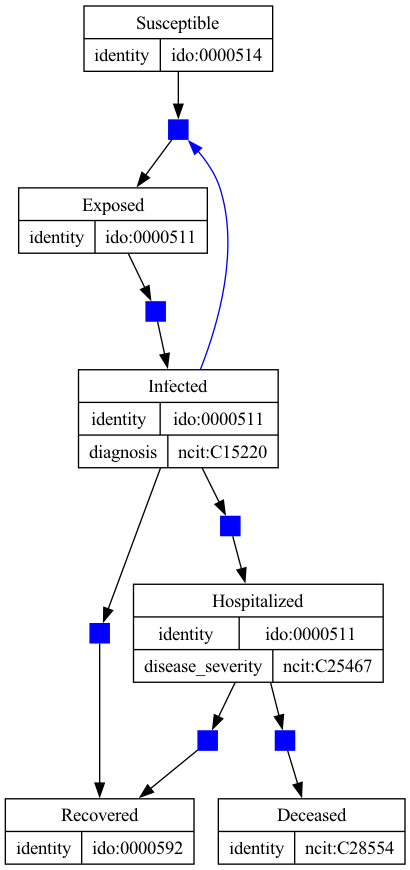

In [ ]:
# %%

GraphicalModel.for_jupyter(model_seirhd)

In [ ]:
# %%

generate_summary_table(model_seirhd)

,name,subject,outcome,controller(s),rate_law,interactor_rate_law
0,t1,S,E,I,I*S*b*invN,I*S
1,t5,E,I,None,E*rEI,E
2,t9,I,R,None,I*pIR*rIR,I
3,t15,H,D,None,H*pHD*rHD,H
4,t16,H,R,None,H*pHR*rHR,H
5,t17,I,H,None,I*pIH*rIH,I


In [ ]:
# %%

generate_odesys(model_seirhd)

[Eq(Derivative(S(t), t), -I*S*b*invN),
 Eq(Derivative(E(t), t), -E*rEI + I*S*b*invN),
 Eq(Derivative(I(t), t), E*rEI - I*pIH*rIH - I*pIR*rIR),
 Eq(Derivative(R(t), t), H*pHR*rHR + I*pIR*rIR),
 Eq(Derivative(H(t), t), -H*pHD*rHD - H*pHR*rHR + I*pIH*rIH),
 Eq(Derivative(D(t), t), H*pHD*rHD)]

# %%[markdown]

 Configure the model

In [ ]:
# %%

# Estimate initial condition from NY dataset

df_cases_cum = pandas.read_csv("./data/monthly_demo_202408/covid_confirmed_usafacts.csv")

t_It = [mpl.dates.datestr2num(s) for s in df_cases_cum.columns[4:]][1:]

# Infectious period ~12 days
i = numpy.argwhere(df_cases_cum.columns == "2020-03-23")[0][0]
j = numpy.argwhere(df_cases_cum.columns == "2020-04-03")[0][0] + 1

# Estimate derivative (incident rate, i.e. new cases per day)
y = numpy.asarray(df_cases_cum[df_cases_cum["State"] == "NY"].iloc[:, 5:]) - numpy.asarray(df_cases_cum[df_cases_cum["State"] == "NY"].iloc[:, 4:-1])
It = y.sum(axis = 0)
I0 = float(y[(i - 5):(j-5)].sum())

Et = It * 0.25
E0 = I0 * 0.25

df_deaths_cum = pandas.read_csv("./data/monthly_demo_202408/covid_deaths_usafacts.csv")
y = numpy.asarray(df_deaths_cum[df_deaths_cum["State"] == "NY"].iloc[:, 5:]) - numpy.asarray(df_deaths_cum[df_deaths_cum["State"] == "NY"].iloc[:, 4:-1])
Dt = y.sum(axis = 0)
D0 = float(Dt[:(j-5)].sum())

t_Dt = [mpl.dates.datestr2num(s) for s in df_deaths_cum.columns[4:]][1:]

# Assumption
# R0 = cumulative_infections - cumulative_deaths at timepoint 2020-04-03
x = df_cases_cum[df_cases_cum["State"] == "NY"].iloc[:, 4:].sum(axis = 0).index
i = numpy.argwhere(numpy.asarray(x) == "2020-04-03")[0][0]

x = df_deaths_cum[df_deaths_cum["State"] == "NY"].iloc[:, 4:].sum(axis = 0).index
j = numpy.argwhere(numpy.asarray(x) == "2020-04-03")[0][0]

R0 = float(df_cases_cum[df_cases_cum["State"] == "NY"].iloc[:, 4:].sum(axis = 0).iloc[i] - df_deaths_cum[df_deaths_cum["State"] == "NY"].iloc[:, 4:].sum(axis = 0).iloc[j])

In [ ]:
# %%

df_hosp = pandas.read_csv("./data/monthly_demo_202408/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW__20240814.csv")

y = df_hosp[df_hosp["state"] == "NY"]
y = y.sort_values(by = ["date"])
t_Ht = [mpl.dates.datestr2num(s) for s in y["date"]]

# "Reported patients currently hospitalized in an inpatient bed who have suspected or confirmed COVID-19 in this state"
Ht = y["inpatient_beds_used_covid"]
H0 = float(numpy.asarray(Ht[df_hosp["date"] == "2020/04/03"])[0])

In [ ]:
# %%

S0 = 19.34e6 - E0 - I0 - R0 - H0 - D0
__ = [print(f"{name} = {x}") for name, x in zip(("S0", "E0", "I0", "R0", "H0", "D0"), (S0, E0, I0, R0, H0, D0))]

S0 = 18779479.75
E0 = 88846.25
I0 = 355385.0
R0 = 99821.0
H0 = 12637.0
D0 = 3831.0


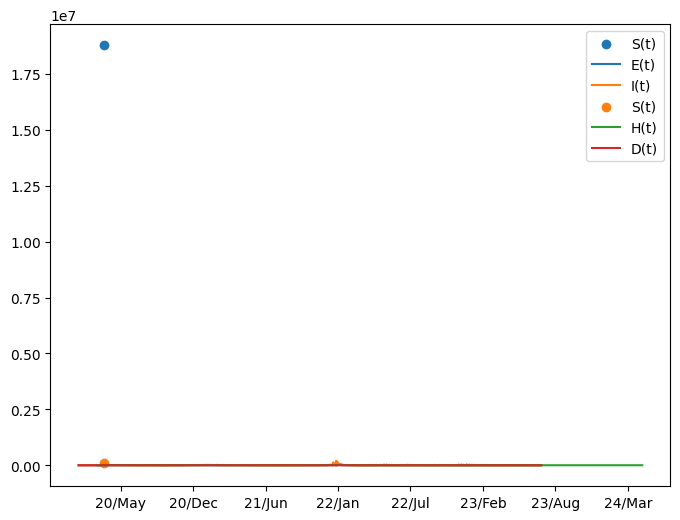

In [ ]:
# %%

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
__ = ax.scatter(mpl.dates.datestr2num("2020-04-03"), S0, label = "S(t)")
__ = ax.plot(t_It, Et, label = "E(t)")
__ = ax.plot(t_It, It, label = "I(t)")
__ = ax.scatter(mpl.dates.datestr2num("2020-04-03"), R0, label = "S(t)")
__ = ax.plot(t_Ht, numpy.asarray(Ht), label = "H(t)")
__ = ax.plot(t_Dt, Dt, label = "D(t)")
__ = ax.legend()
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%y/%b"))
# __ = plt.setp(ax, yscale = "log")

In [ ]:
# %%

# Note: tedious to require existing parameter to add a value
model_seirhd.add_parameter(parameter_id = "S0", name = "S0")
model_seirhd.add_parameter(parameter_id = "E0", name = "E0")
model_seirhd.add_parameter(parameter_id = "I0", name = "I0")
model_seirhd.add_parameter(parameter_id = "R0", name = "R0")
model_seirhd.add_parameter(parameter_id = "H0", name = "H0")
model_seirhd.add_parameter(parameter_id = "D0", name = "D0")

model_seirhd.set_parameters(
    param_dict = {
        "b": 0.4,
        "invN": 1.0 / 19.34e6,
        "rEI": 0.2,
        "rIR": 0.07,
        "rIH": 0.1,
        "rHR": 0.1,
        "rHD": 0.1,
        "pIR": 0.8,
        "pIH": 0.2,
        "pHR": 0.88,
        "pHD": 0.12,
        "S0": S0,
        "E0": E0, # 530863,
        "I0": I0, # 2123452,
        "R0": R0, # 2069902,
        "H0": H0, # 744,
        "D0": D0, # 53550,
    }
)

model_seirhd.set_initials(
    initial_dict = {
        "S": sympy.Symbol("S0"),
        "E": sympy.Symbol("E0"),
        "I": sympy.Symbol("I0"),
        "R": sympy.Symbol("R0"),
        "H": sympy.Symbol("H0"),
        "D": sympy.Symbol("D0"),
    }
)

In [ ]:
# %%

# Workaround
amr = add_missing_distributions(add_missing_parameter_names(template_model_to_petrinet_json(model_seirhd)))
model_seirhd = template_model_from_amr_json(amr)

generate_init_param_tables(model_seirhd)[0]

,name,expression
0,S,S0
1,I,I0
2,E,E0
3,R,R0
4,H,H0
5,D,D0


In [ ]:
# %%

generate_init_param_tables(model_seirhd)[1]

,name,value
0,b,4.000000e-01
1,invN,5.170631e-08
2,rEI,2.000000e-01
3,pIR,8.000000e-01
4,rIR,7.000000e-02
5,pHD,1.200000e-01
6,rHD,1.000000e-01
7,pHR,8.800000e-01
8,rHR,1.000000e-01
9,pIH,2.000000e-01


In [ ]:
# %%

# Save as AMR
with open("./data/monthly_demo_202408/model_seirhd.json", "w") as f:
    j = template_model_to_petrinet_json(model_seirhd)
    json.dump(j, f, indent = 4)

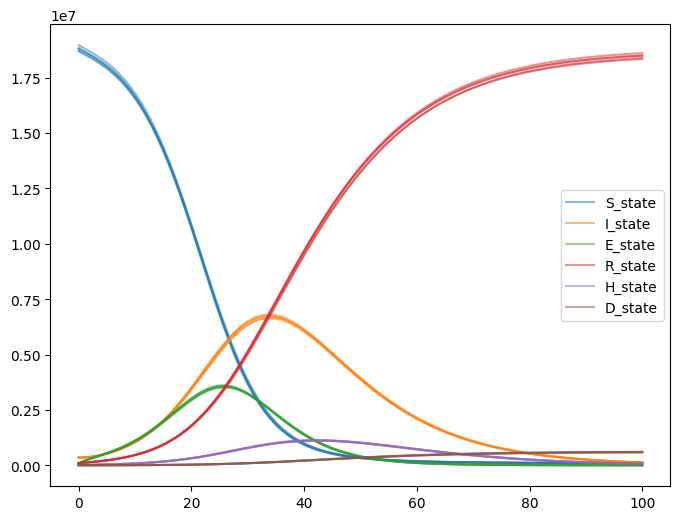

In [ ]:
# %%

# Run this model

start_time = 0.0
end_time = 100.0
logging_step_size = 1.0
num_samples = 5

results = pyciemss.sample(
    add_missing_parameter_names(template_model_to_petrinet_json(model_seirhd)), 
    end_time, 
    logging_step_size, 
    num_samples, 
    start_time = start_time
)

# Plot results
plot_simulate_results(results)

# Note:
# 

# %%[markdown]

 ### Question 1ii(1)

 Replace the parameter `b` with `b * (1 - epsilon_m * c_m)`

In [ ]:
# %%

model_seirhd_mod = copy.deepcopy(model_seirhd)

# Add new parameters
model_seirhd_mod.add_parameter(parameter_id = "epsilonM", value = 0.0)
model_seirhd_mod.add_parameter(parameter_id = "cM", value = 0.0)

# Replace the t1 rate law
amr = template_model_to_petrinet_json(model_seirhd_mod)
amr = replace_rate_law_sympy(amr, "t1", new_rate_law = sympy.Symbol("b") * (1 - sympy.Symbol("epsilonM") * sympy.Symbol("cM")) * sympy.Symbol("invN") * sympy.Symbol("S") * sympy.Symbol("I"))

model_seirhd_mod = template_model_from_amr_json(amr)

# Rename the model
model_seirhd_mod.annotations.name = "SEIRHD model (modified beta)"
model_seirhd_mod.annotations.description = "Edit of the SIDARTHE model from Giodano 2020 with beta modified per Srivastava 2021."

generate_odesys(model_seirhd_mod)

[Eq(Derivative(S(t), t), -I*S*b*invN*(-cM*epsilonM + 1)),
 Eq(Derivative(E(t), t), -E*rEI + I*S*b*invN*(-cM*epsilonM + 1)),
 Eq(Derivative(I(t), t), E*rEI - I*pIH*rIH - I*pIR*rIR),
 Eq(Derivative(R(t), t), H*pHR*rHR + I*pIR*rIR),
 Eq(Derivative(H(t), t), -H*pHD*rHD - H*pHR*rHR + I*pIH*rIH),
 Eq(Derivative(D(t), t), H*pHD*rHD)]

In [ ]:
# %%

# Workaround
amr = add_missing_distributions(add_missing_parameter_names(template_model_to_petrinet_json(model_seirhd_mod)))
model_seirhd_mod = template_model_from_amr_json(amr)

In [ ]:
# %%

# Save as AMR
with open("./data/monthly_demo_202408/model_seirhd_mod.json", "w") as f:
    j = template_model_to_petrinet_json(model_seirhd_mod)
    json.dump(j, f, indent = 4)

# %%[markdown]

 ### Question 1ii(2)

 Replace `b` with a time-varying function

 This should be done as an static parameter intervention since it's just two step functions

# %%[markdown]

 ### Question 1ii(3)

 Edit model to include masking/non-masking populations

In [ ]:
# %%

# Let's stratify the model by masking compliance (n = noncompliant, c = compliant)

model_seirhd_mod_mask = mira.metamodel.stratify(
    model_seirhd_mod,
    key = "masking",
    strata = ['n', 'c'],
    structure = [['n', 'c']],
    directed = False,
    concepts_to_stratify = {'S', 'E', 'I'},
    params_to_stratify = {'epsilonM', 'cM'},
    cartesian_control = True,
    # param_renaming_uses_strata_names = True
)

GraphicalModel.for_jupyter(model_seirhd_mod_mask)

# Rename the model
model_seirhd_mod_mask.annotations.name = "SEIRHD model (modified beta, stratified by masking)"
model_seirhd_mod_mask.annotations.description = "Edit of the SIDARTHE model from Giodano 2020 with beta modified per Srivastava 2021 and stratified by masking compliance."

In [ ]:
# %%

# Workaround
amr = add_missing_distributions(add_missing_parameter_names(template_model_to_petrinet_json(model_seirhd_mod_mask)))
model_seirhd_mod_mask = template_model_from_amr_json(amr)

In [ ]:
# %%

# Save as AMR
with open("./data/monthly_demo_202408/model_seirhd_mod_mask.json", "w") as f:
    j = template_model_to_petrinet_json(model_seirhd_mod_mask)
    json.dump(j, f, indent = 4)

# %%[markdown]

 ### Question 2

 Stratify instead by 18 age groups

In [ ]:
# %%

model_seirhd_age = mira.metamodel.stratify(
    copy.deepcopy(model_seirhd),
    key = "age",
    strata = [f"{i}" for i in range(18)],
    structure = [],
    directed = False, 
    concepts_to_stratify = ["S", "I"],
    params_to_stratify = ["b"],
    cartesian_control = True
)

model_seirhd_age.annotations.name = "SEIRHD model (stratified by age)"
model_seirhd_age.annotations.description = "Edit of the SIDARTHE model from Giodano 2020, stratified by 18 age groups."

In [ ]:
# %%

# Workaround
amr = add_missing_distributions(add_missing_parameter_names(template_model_to_petrinet_json(model_seirhd_age)))
model_seirhd_age = template_model_from_amr_json(amr)

In [ ]:
# %%

# Save as AMR
with open("./data/monthly_demo_202408/model_seirhd_age.json", "w") as f:
    j = template_model_to_petrinet_json(model_seirhd_age)
    json.dump(j, f, indent = 4)

# %%[markdown]

 ## Problem 3

 12-month evaluation, scenario 2

 ###